# CNNS and Autoencoders

In [157]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [109]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

In [110]:
print(mnist_train.targets.size())

torch.Size([60000])


In [111]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [112]:
print(mnist_test.data.size())

torch.Size([10000, 28, 28])


### Visualizing the data

In [113]:
labels = np.array([item[1] for item in mnist_train])
label_counts = Counter(labels)
print(label_counts)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


<BarContainer object of 10 artists>

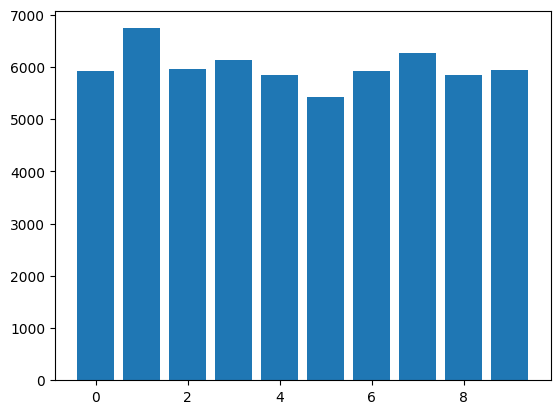

In [89]:
label_counts = dict(sorted(label_counts.items()))
labels = list(label_counts.keys())
values = list(label_counts.values())
plt.bar(labels, values)

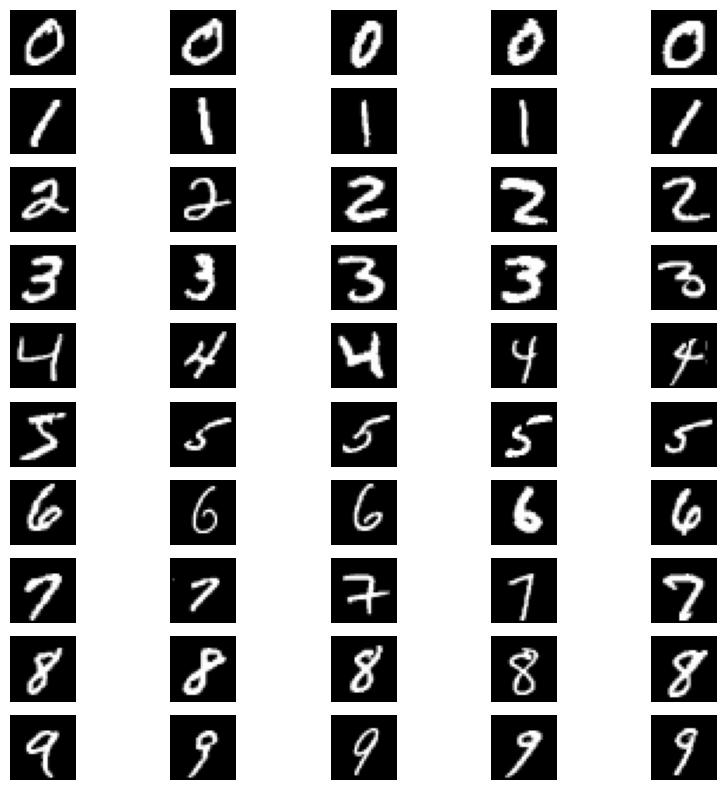

In [90]:
digits = {}
digit_count = {str(i): 0 for i in range(10)}

for img, label in mnist_train:
    label = str(label)
    if digit_count[label] < 5:
        if label not in digits:
            digits[label] = []
        digits[label].append(img)
        digit_count[label] += 1

fig, axes = plt.subplots(10, 5, figsize=(10, 10))

for digit in range(10):
    for i in range(5):
        ax = axes[digit, i]
        ax.imshow(digits[str(digit)][i].reshape(28,28), cmap="gray")
        ax.axis("off")

plt.show()

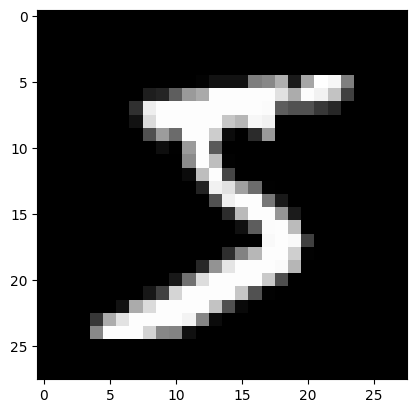

In [91]:
plt.imshow(mnist_train.data[0], cmap = "gray")
plt.show()

In [223]:
test_dataset, val_dataset = random_split(mnist_test, [int(mnist_test.data.size(0)*0.8), int(mnist_test.data.size(0)*0.2)])

In [120]:
def loaddata(batchsize):
  loaders = {
      'train' : torch.utils.data.DataLoader(mnist_train,
                                            batch_size=batchsize,
                                            shuffle=True,
                                            num_workers=1),

      'test'  : torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batchsize,
                                            shuffle=True,
                                            num_workers=1),

      'val'   : torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batchsize,
                                            shuffle=True,
                                            num_workers=1),
  }
  return loaders

In [ ]:
def visualize_feature_maps(model, input_image):
    feature_maps1 = None
    feature_maps2 = None

    def hook_fn1(module, input, output):
        nonlocal feature_maps1
        feature_maps1 = output

    def hook_fn2(module, input, output):
        nonlocal feature_maps2
        feature_maps2 = output

    # capture feature maps
    model.conv1[0].register_forward_hook(hook_fn1)
    model.conv2[0].register_forward_hook(hook_fn2)

    with torch.no_grad():
        model(input_image)

    feature_maps1 = feature_maps1.squeeze(0).cpu().numpy()
    feature_maps2 = feature_maps2.squeeze(0).cpu().numpy()

    plt.figure(figsize=(15, 5))
    plt.suptitle('Feature Maps Visualization: Conv1')

    # Visualize feature maps from self.conv1
    for i in range(feature_maps1.shape[0]):
        plt.subplot(1, feature_maps1.shape[0], i + 1)
        plt.imshow(feature_maps1[i])
        plt.axis('off')

    plt.show()

    plt.figure(figsize=(15, 5))
    plt.suptitle('Feature Maps Visualization: Conv2')

    # Visualize feature maps from self.conv2
    for i in range(feature_maps2.shape[0]):
        plt.subplot(1, feature_maps2.shape[0], i + 1)
        plt.imshow(feature_maps2[i])
        plt.axis('off')

    plt.show()

### The model

In [124]:
class CNN(nn.Module):
  def __init__(self): # the number of input channels is 1 (black and white images), the number of classes is 10
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5,
                  stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    # same convolution (input size is preserved)
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5,
                  stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Linear(16*7*7, 10) # 16 is the number of output channels, 7 is after the max pooling twice (28->14->7)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    output = self.fc(x)
    return output

  def fit(self, data, lr, epochs):
    # cross entropy loss includes softmax, so i havent done that separately
    # otherwise, i can do softmax with nllloss
    lossfunc = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr = lr)
    self.train()
    for epoch in range(epochs):
      total_loss = 0.0
      correct_train = 0
      total_train = 0
      correct_val = 0
      total_val = 0
      self.train()

      for i, (images, labels) in enumerate(data['train']):
          output = self(images)
          loss = lossfunc(output, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

          _, predicted = torch.max(output.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      self.eval()
      for i, (images, labels) in enumerate(data['val']):
          output = self(images)

          _, predicted = torch.max(output.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

      epoch_loss = total_loss / len(data['train'])
      epoch_train_accuracy = 100 * correct_train / total_train
      epoch_val_accuracy = 100 * correct_val / total_val

      print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch + 1, epochs, epoch_loss))
      print('Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(epoch_train_accuracy, epoch_val_accuracy))

In [125]:
model = CNN()
loaders = loaddata(100)
model.fit(loaders, 0.01, 10)

Epoch [1/10], Train Loss: 0.1540
Train Accuracy: 95.13%, Validation Accuracy: 98.25%
Epoch [2/10], Train Loss: 0.0681
Train Accuracy: 97.86%, Validation Accuracy: 98.50%
Epoch [3/10], Train Loss: 0.0599
Train Accuracy: 98.17%, Validation Accuracy: 98.85%
Epoch [4/10], Train Loss: 0.0579
Train Accuracy: 98.20%, Validation Accuracy: 98.40%
Epoch [5/10], Train Loss: 0.0520
Train Accuracy: 98.40%, Validation Accuracy: 98.80%
Epoch [6/10], Train Loss: 0.0541
Train Accuracy: 98.38%, Validation Accuracy: 98.90%
Epoch [7/10], Train Loss: 0.0538
Train Accuracy: 98.37%, Validation Accuracy: 98.55%
Epoch [8/10], Train Loss: 0.0543
Train Accuracy: 98.40%, Validation Accuracy: 98.85%
Epoch [9/10], Train Loss: 0.0501
Train Accuracy: 98.49%, Validation Accuracy: 98.70%
Epoch [10/10], Train Loss: 0.0494
Train Accuracy: 98.57%, Validation Accuracy: 98.15%


In [158]:
def test(model, data_loader):
    model.eval()
    truelabels = []
    predictedlabels = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader['test']):
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]

            truelabels.extend(labels.cpu().numpy())
            predictedlabels.extend(pred_y.cpu().numpy())

    correct = np.sum(np.array(truelabels) == np.array(predictedlabels))
    total = len(truelabels)
    accuracy = correct / total

    target_names = [str(i) for i in range(10)]  # Replace with class labels
    report = classification_report(truelabels, predictedlabels, target_names=target_names)
    return accuracy, report


accuracy, report = test(model, loaders)

print('Test Accuracy of the model on the test dataset: %.2f' % (accuracy * 100))
print(report)


Test Accuracy of the model on the test dataset: 98.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       797
           1       0.99      1.00      0.99       907
           2       0.99      0.99      0.99       812
           3       0.99      0.99      0.99       779
           4       0.99      0.98      0.98       790
           5       0.99      1.00      0.99       717
           6       1.00      0.99      0.99       751
           7       0.99      0.98      0.99       834
           8       0.99      0.99      0.99       774
           9       0.98      0.99      0.98       839

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



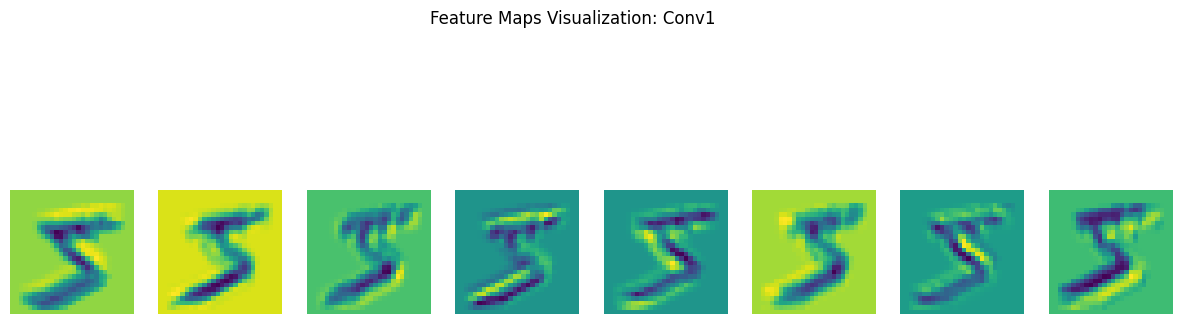

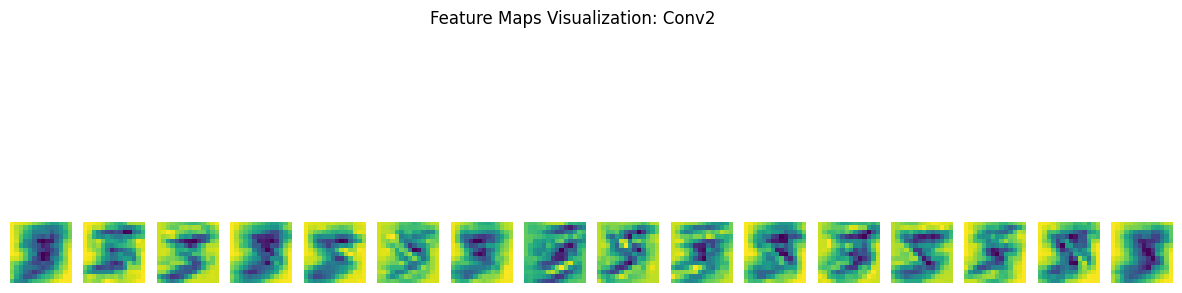

In [ ]:
image_index = 0
input_image = mnist_train.data[image_index].unsqueeze(0).unsqueeze(0).float()  # Add batch and channel dimensions

# Visualize feature maps for the first image
visualize_feature_maps(model, input_image)

### Hyperparameter Tuning using WandB

In [13]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=2387d644de541f506db04f31c8ca9048f4f8071c4f138ee42eaa9814430d98e9
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [1]:
import wandb

In [3]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [13]:
class CNN_wandb(nn.Module):
  def __init__(self, kernelsizes, strides, dropouts): # the number of input channels is 1 (black and white images), the number of classes is 10
    super(CNN_wandb, self).__init__()
    maxpool = 2
    if strides > 1:
      maxpool = 1
    padding = 2
    if kernelsizes == 3:
      padding = 1
    self.kernelsize = kernelsizes
    self.stride = strides
    self.dropout = dropouts
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = kernelsizes,
                  stride = strides, padding = padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = maxpool, stride = maxpool)
    )
    # same convolution (input size is preserved)
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = kernelsizes,
                  stride = strides, padding = padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = maxpool, stride = maxpool)
    )
    self.dropout = nn.Dropout(dropouts)
    self.fc = nn.Linear(16*7*7, 10) # 16 is the number of output channels, 7 is after the max pooling twice (28->14->7)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    output = self.fc(x)
    return output

  def fit(self, data, lr, epochs, batchsize):
    # cross entropy loss includes softmax, so i havent done that separately
    # otherwise, i can do softmax with nllloss
    lossfunc = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr = lr)
    self.train()

    wandb.init(settings=wandb.Settings(start_method="fork"),
               project = "assignment-3 part-4",
               name = f"{epochs}, {batchsize}, {self.kernelsize}, {self.stride}, {self.dropout}, {lr}",
               config={"epochs": epochs,
                        "batchsize": batchsize,
                        "kernelsize": self.kernelsize,
                        "strides": self.stride,
                        "dropouts": self.dropout,
                        "learningrate": lr})
    for epoch in range(epochs):
      total_loss = 0.0
      correct_train = 0
      total_train = 0
      correct_val = 0
      total_val = 0
      self.train()

      for i, (images, labels) in enumerate(data['train']):
          output = self(images)
          loss = lossfunc(output, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

          _, predicted = torch.max(output.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      self.eval()
      for i, (images, labels) in enumerate(data['val']):
          output = self(images)

          _, predicted = torch.max(output.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

      epoch_loss = total_loss / len(data['train'])
      epoch_train_accuracy = 100 * correct_train / total_train
      epoch_val_accuracy = 100 * correct_val / total_val
      wandb.log({"loss": epoch_loss, "train accuracy": epoch_train_accuracy, "val_accuracy": epoch_val_accuracy})

    wandb.finish()


In [ ]:
epochss = [5, 10]
batchsizes = [100, 400]
kernelsizes = [3, 5]
strides = [1, 2]
dropouts = [0.2, 0.5]
learningrates = [0.005, 0.01]
for epochs in epochss:
  for batchsize in batchsizes:
    for kernelsize in kernelsizes:
      for stride in strides:
        for dropout in dropouts:
          for lr in learningrates:
            model = CNN_wandb(kernelsize, stride, dropout)
            loaders = loaddata(batchsize)
            model.fit(loaders, lr, epochs, batchsize)

In [ ]:
# models that run for 10 epochs perform objectively better

In [127]:
model = CNN()
loaders = loaddata(400)
model.fit(loaders, 0.01, 10)

Epoch [1/10], Train Loss: 0.2563
Train Accuracy: 91.98%, Validation Accuracy: 98.30%
Epoch [2/10], Train Loss: 0.0698
Train Accuracy: 97.86%, Validation Accuracy: 98.75%
Epoch [3/10], Train Loss: 0.0540
Train Accuracy: 98.33%, Validation Accuracy: 99.10%
Epoch [4/10], Train Loss: 0.0467
Train Accuracy: 98.50%, Validation Accuracy: 98.85%
Epoch [5/10], Train Loss: 0.0430
Train Accuracy: 98.62%, Validation Accuracy: 99.15%
Epoch [6/10], Train Loss: 0.0397
Train Accuracy: 98.74%, Validation Accuracy: 99.05%
Epoch [7/10], Train Loss: 0.0360
Train Accuracy: 98.91%, Validation Accuracy: 98.85%
Epoch [8/10], Train Loss: 0.0347
Train Accuracy: 98.91%, Validation Accuracy: 99.05%
Epoch [9/10], Train Loss: 0.0328
Train Accuracy: 98.97%, Validation Accuracy: 99.25%
Epoch [10/10], Train Loss: 0.0327
Train Accuracy: 98.95%, Validation Accuracy: 99.30%


In [46]:
def test_with_classes(model, data_loader):
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10
    all_preds = []
    all_labels = []
    misclassified = []

    with torch.no_grad():
      for i, (images, labels) in enumerate(data_loader):
        test_output = model(images)
        pred_y = torch.max(test_output, 1)[1]
        all_preds.extend(pred_y.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for j in range(10):
          class_correct[j] += (pred_y == labels)[labels == j].sum().item()
          class_total[j] += (labels == j).sum().item()

        for j in range(len(images)):
          if pred_y[j] != labels[j]:
            misclassified.append((images[j], labels[j], pred_y[j]))


    total_correct = sum(class_correct)
    total_total = sum(class_total)
    overall_accuracy = total_correct / total_total

    print('Overall Accuracy on the Test Dataset: %.2f%%' % (overall_accuracy * 100))

    for i in range(10):
      class_acc = class_correct[i] / class_total[i]
      print('Accuracy for Class %d: %.2f%%' % (i, class_acc * 100))

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return cm, misclassified


### Evaluating the model

In [47]:
cm, misclassified = test_with_classes(model, loaders['test'])
print('Confusion Matrix:')
print(cm)

Overall Accuracy on the Test Dataset: 99.17%
Accuracy for Class 0: 99.12%
Accuracy for Class 1: 99.78%
Accuracy for Class 2: 99.40%
Accuracy for Class 3: 99.38%
Accuracy for Class 4: 98.96%
Accuracy for Class 5: 99.30%
Accuracy for Class 6: 99.48%
Accuracy for Class 7: 98.57%
Accuracy for Class 8: 99.35%
Accuracy for Class 9: 98.37%
Confusion Matrix:
[[790   0   1   0   0   0   4   0   1   1]
 [  0 903   0   0   0   0   2   0   0   0]
 [  1   1 827   0   0   0   1   0   2   0]
 [  0   0   1 804   0   1   0   1   2   0]
 [  0   1   0   0 760   0   1   0   1   5]
 [  1   0   0   2   0 706   1   0   0   1]
 [  0   2   0   0   1   1 768   0   0   0]
 [  0   3   3   0   0   1   0 828   1   4]
 [  3   0   0   1   0   1   0   0 762   0]
 [  0   0   0   0   3   4   1   2   3 786]]


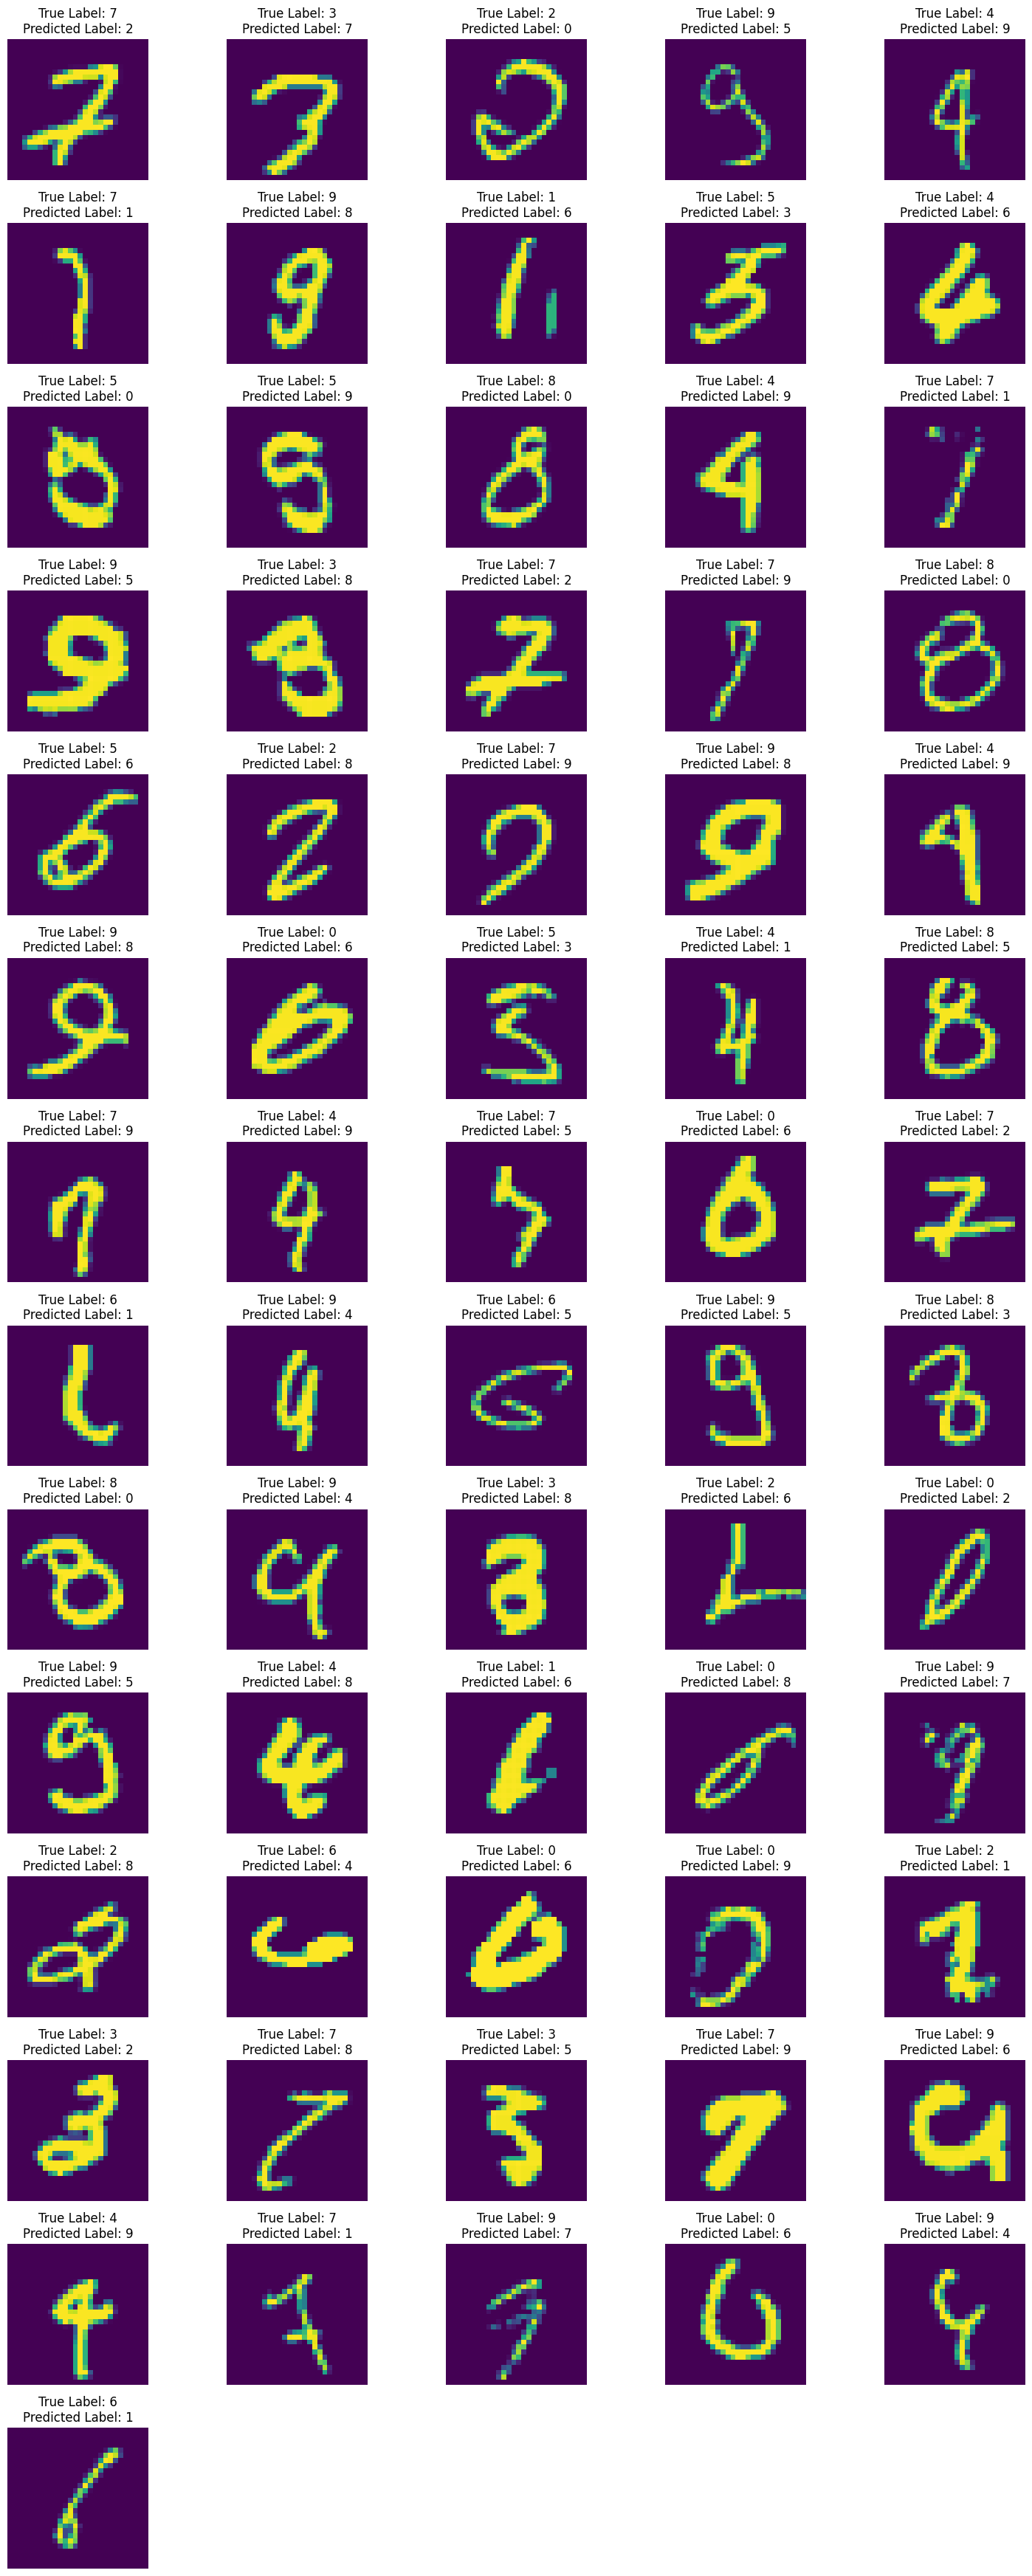

In [51]:
samples = len(misclassified)
rows = int((samples + 4) / 5 )

plt.figure(figsize=(15, 2.5 * rows))

for i, (image, true_label, predicted_label) in enumerate(misclassified):
    plt.subplot(rows, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


These samples appear misclassified. \
One of the main reasons for this is that most of them lack the special charactersitic of the number that allows us to uniquely identify the number. \
In a lot of these cases, humans will also struggle to correctly classify the digis.

## Denoising the images

In [55]:
mnist_with_awgn = sio.loadmat('/content/mnist-with-awgn.mat')

In [56]:
mnist_with_awgn

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Nov 16 16:53:32 2014',
 '__version__': '1.0',
 '__globals__': [],
 'train_x': array([[  0,   0,  11, ...,  59,   2,  91],
        [  0,  41,   0, ...,   0, 106,   0],
        [  0,  23,  71, ...,  36,   0,  67],
        ...,
        [ 38,  36,   0, ...,   0, 119,   0],
        [ 82,   4,   0, ...,   0,   0,  30],
        [  0,   0, 193, ...,  15,   0,  79]], dtype=uint8),
 'test_x': array([[129,   0, 129, ...,   0,  52,   0],
        [  0,  65, 171, ..., 126,   0,   0],
        [  0,  49, 176, ...,   0,  71,   0],
        ...,
        [ 47,  54,   0, ...,  58,   0,   0],
        [  0,   4,   0, ...,   8,   7,  89],
        [  0,  61, 130, ...,   0,   0,  49]], dtype=uint8),
 'train_y': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 'test_y

In [218]:
X_train = mnist_with_awgn['train_x']
X_test = mnist_with_awgn['test_x']
y_train = mnist_with_awgn['train_y']
y_test = mnist_with_awgn['test_y']

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

y_train = torch.argmax(y_train, dim=1)
y_test = torch.argmax(y_test, dim=1)

X_train = X_train.view(X_train.size(0), 1, 28, 28)
X_test = X_test.view(X_test.size(0), 1, 28, 28)

# Create TensorDatasets
traindataset = TensorDataset(X_train, y_train)
testdataset = TensorDataset(X_test, y_test)

test_size = int(len(testdataset)*0.8)
val_size = len(testdataset) - test_size

testdataset, valdataset = random_split(testdataset, [test_size, val_size])

# Create DataLoaders
noisyloaders = {
    'train' : DataLoader(traindataset, batch_size=400, shuffle=True),

    'test'  : DataLoader(testdataset, batch_size=400, shuffle=False),

    'val'   : DataLoader(valdataset, batch_size=400, shuffle=False)
}

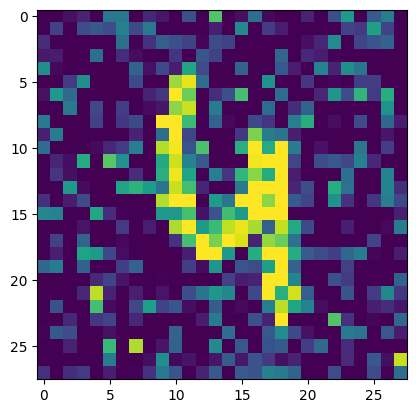

In [59]:
image = X_train[0].squeeze().numpy()
plt.imshow(image)
plt.show()

In [137]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [155]:
# train the best model on the noisy data
noisymodel = CNN()
noisymodel.fit(noisyloaders, 0.01, 10)

Epoch [1/10], Train Loss: 2.2361
Train Accuracy: 53.26%, Validation Accuracy: 81.50%
Epoch [2/10], Train Loss: 0.6251
Train Accuracy: 79.78%, Validation Accuracy: 88.20%
Epoch [3/10], Train Loss: 0.5313
Train Accuracy: 82.79%, Validation Accuracy: 88.85%
Epoch [4/10], Train Loss: 0.4919
Train Accuracy: 83.97%, Validation Accuracy: 89.15%
Epoch [5/10], Train Loss: 0.4622
Train Accuracy: 85.05%, Validation Accuracy: 88.55%
Epoch [6/10], Train Loss: 0.4638
Train Accuracy: 84.83%, Validation Accuracy: 89.90%
Epoch [7/10], Train Loss: 0.4293
Train Accuracy: 86.03%, Validation Accuracy: 90.40%
Epoch [8/10], Train Loss: 0.4318
Train Accuracy: 86.16%, Validation Accuracy: 91.45%
Epoch [9/10], Train Loss: 0.4081
Train Accuracy: 86.90%, Validation Accuracy: 91.45%
Epoch [10/10], Train Loss: 0.4137
Train Accuracy: 86.72%, Validation Accuracy: 92.25%


In [159]:
accuracy, report = test(noisymodel, noisyloaders)

print('Test Accuracy of the model on the test dataset: %.2f' % (accuracy * 100))
print(report)

Test Accuracy of the model on the test dataset: 93.00
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       794
           1       0.98      0.98      0.98       903
           2       0.92      0.92      0.92       821
           3       0.94      0.88      0.91       800
           4       0.96      0.92      0.94       788
           5       0.88      0.95      0.92       703
           6       0.97      0.93      0.95       783
           7       0.91      0.95      0.93       787
           8       0.91      0.88      0.89       795
           9       0.89      0.90      0.90       826

    accuracy                           0.93      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.93      0.93      0.93      8000



### Autoencoders

#### Create a noisy dataset from the mnistdataset

In [228]:
def addnoise(dataset):
  noisy_dataset = []
  noise_factor = 0.3
  for img, label in dataset:
      noisy_img = img + noise_factor * torch.randn_like(img)
      noisy_img = torch.clamp(noisy_img, 0, 1)
      noisy_dataset.append((noisy_img, label))
  return noisy_dataset

In [229]:
train_noisy = addnoise(mnist_train)
test_noisy = addnoise(test_dataset)
val_noisy = addnoise(val_dataset)

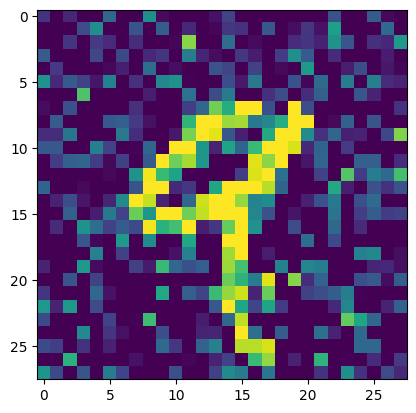

In [230]:
image, label = train_noisy[4]
plt.imshow(image.permute(1, 2, 0).numpy())

In [233]:
noisedloader = {
    'train' : DataLoader(train_noisy, batch_size=400, shuffle=False),

    'test'  : DataLoader(test_noisy, batch_size=400, shuffle=False),

    'val'   : DataLoader(val_noisy, batch_size=400, shuffle=False)
}

In [234]:
groundloader = {
      'train' : DataLoader(mnist_train, batch_size=400, shuffle=False),

      'test'  : DataLoader(test_dataset, batch_size=400, shuffle=False),

      'val'   : DataLoader(val_dataset, batch_size=400, shuffle=False)
}

In [289]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 128),  # input size is 784 (28*28)
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(128, 784),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def fit(self, data_noised, data_real, lr, epochs):
    lossfunc = nn.MSELoss()
    optimizer = optim.Adam(self.parameters(), lr = lr)
    for epoch in range(epochs):
      self.train()
      total_loss = 0.0
      zipped_data = zip(data_noised['train'], data_real['train'])

      for i, ((noised_images, _), (real_images, _)) in enumerate(zipped_data):
        optimizer.zero_grad()
        noised_output = self(noised_images)
        real_images = real_images.view(real_images.size(0), -1)
        loss = lossfunc(noised_output, real_images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      self.eval()
      val_loss = 0.0
      zipped_data = zip(data_noised['val'], data_real['val'])
      for i, ((noised_images, _), (real_images, _)) in enumerate(zipped_data):
          output = self(noised_images)
          real_images = real_images.view(real_images.size(0), -1)
          loss = lossfunc(output, real_images)
          val_loss += loss.item()

      epoch_loss = total_loss / len(data_noised['train'])
      epoch_val = val_loss / len(data_noised['val'])

      print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch + 1, epochs, epoch_loss, epoch_val))
      # print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch + 1, epochs, epoch_loss))

In [290]:
autoencoder = Autoencoder()
autoencoder.fit(noisedloader, groundloader, 0.01, 10)

Epoch [1/10], Train Loss: 0.0380, Val Loss: 0.0174
Epoch [2/10], Train Loss: 0.0145, Val Loss: 0.0132
Epoch [3/10], Train Loss: 0.0120, Val Loss: 0.0118
Epoch [4/10], Train Loss: 0.0112, Val Loss: 0.0114
Epoch [5/10], Train Loss: 0.0109, Val Loss: 0.0112
Epoch [6/10], Train Loss: 0.0107, Val Loss: 0.0111
Epoch [7/10], Train Loss: 0.0106, Val Loss: 0.0109
Epoch [8/10], Train Loss: 0.0105, Val Loss: 0.0106
Epoch [9/10], Train Loss: 0.0104, Val Loss: 0.0105
Epoch [10/10], Train Loss: 0.0103, Val Loss: 0.0103


In [291]:
def denoise(model, data, partofdata):
  denoised_dataset = []

  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(data[partofdata]):
      test_output = autoencoder(images)
      unflattened_images = test_output.view(400, 1, 28, 28)
      for j in range(unflattened_images.size(0)):
        denoised_image = unflattened_images[j]
        denoised_label = labels[j]
        denoised_dataset.append((denoised_image, denoised_label))


  return denoised_dataset



In [292]:
denoised_train = denoise(autoencoder, noisyloaders, 'train')
denoised_test = denoise(autoencoder, noisyloaders, 'test')
denoised_val = denoise(autoencoder, noisyloaders, 'test')

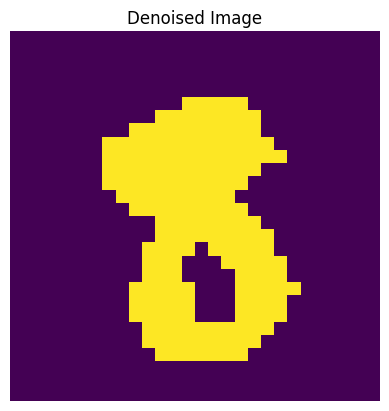

tensor(8)


In [303]:
denoised_image = denoised_train[3][0]

# Plot the denoised image
plt.imshow(denoised_image.permute(1, 2, 0).numpy())
plt.title("Denoised Image")
plt.axis('off')  # Turn off axis labels
plt.show()
print(denoised_train[3][1])

In [298]:
denoisedloaders = {
    'train' : DataLoader(denoised_train, batch_size=400, shuffle=True),

    'test'  : DataLoader(denoised_test, batch_size=400, shuffle=False),

    'val'   : DataLoader(denoised_val, batch_size=400, shuffle=False)
}

In [299]:
# train the best model on the denoised data
denoisedmodel = CNN()
denoisedmodel.fit(denoisedloaders, 0.01, 10)

Epoch [1/10], Train Loss: 0.3726
Train Accuracy: 87.75%, Validation Accuracy: 95.61%
Epoch [2/10], Train Loss: 0.1559
Train Accuracy: 95.14%, Validation Accuracy: 96.26%
Epoch [3/10], Train Loss: 0.1320
Train Accuracy: 95.76%, Validation Accuracy: 96.62%
Epoch [4/10], Train Loss: 0.1184
Train Accuracy: 96.18%, Validation Accuracy: 96.86%
Epoch [5/10], Train Loss: 0.1065
Train Accuracy: 96.59%, Validation Accuracy: 97.28%
Epoch [6/10], Train Loss: 0.1036
Train Accuracy: 96.68%, Validation Accuracy: 97.08%
Epoch [7/10], Train Loss: 0.0984
Train Accuracy: 96.83%, Validation Accuracy: 97.22%
Epoch [8/10], Train Loss: 0.0976
Train Accuracy: 96.83%, Validation Accuracy: 97.24%
Epoch [9/10], Train Loss: 0.0923
Train Accuracy: 96.94%, Validation Accuracy: 97.19%
Epoch [10/10], Train Loss: 0.0893
Train Accuracy: 97.01%, Validation Accuracy: 97.11%


In [300]:
cm, misclassified = test_with_classes(denoisedmodel, denoisedloaders['test'])
print('Confusion Matrix:')
print(cm)

Overall Accuracy on the Test Dataset: 97.11%
Accuracy for Class 0: 99.37%
Accuracy for Class 1: 99.22%
Accuracy for Class 2: 97.36%
Accuracy for Class 3: 98.74%
Accuracy for Class 4: 97.68%
Accuracy for Class 5: 95.41%
Accuracy for Class 6: 97.58%
Accuracy for Class 7: 97.62%
Accuracy for Class 8: 95.67%
Accuracy for Class 9: 92.00%
Confusion Matrix:
[[788   0   0   1   0   1   2   1   0   0]
 [  0 891   1   1   1   1   1   1   1   0]
 [  3   2 812   7   2   1   0   5   2   0]
 [  0   0   2 783   0   3   0   2   1   2]
 [  0   1   1   0 757   0   3   0   3  10]
 [  2   0   0  21   0 665   4   1   3   1]
 [  4   3   0   2   2   5 765   0   3   0]
 [  0   4   4   6   2   0   0 820   1   3]
 [  5   1   1  12   1   3   2   5 752   4]
 [  0   4   0   9  14  12   1  19   5 736]]


Accuracies after denoising the data and then training are a lot higher as compared to just training the data on the noised dataset.